Выгрузим данные:

In [2]:
import pandas as pd

df_train = pd.read_csv('train_spam.csv')
df_train['text_type'] = (df_train['text_type'] == 'spam').astype(int)

df_test = pd.read_csv('test_spam.csv')
df_test['text_type'] = None

df_train

,text_type,text
0,0,make sure alex knows his birthday is over in f...
1,0,a resume for john lavorato thanks vince i will...
2,1,plzz visit my website moviesgodml to get all m...
3,1,urgent your mobile number has been awarded wit...
4,0,overview of hr associates analyst project per ...
...,...,...
16273,1,if you are interested in binary options tradin...
16274,1,dirty pictureblyk on aircel thanks you for bei...
16275,0,or you could do this g on mon 1635465 sep 1635...
16276,0,insta reels par 80 गंद bhara pada hai 👀 kuch b...


Посмотрим на распределение классов. \
Можно заметить, что положительного класса в ~2 раза меньше, чем отрицательного

<Axes: >

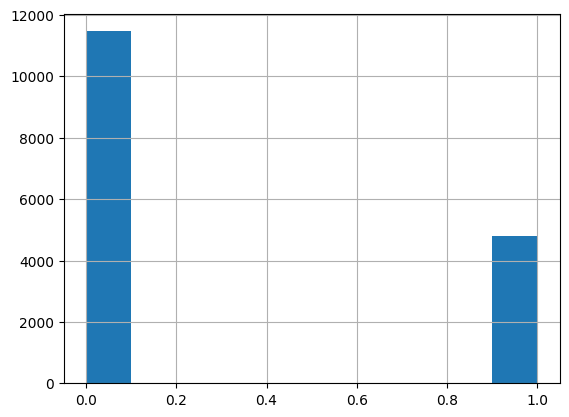

In [3]:
df_train['text_type'].hist()

Для оценки необходимо использовать метрику auc-roc.
P.s. мне кажется, для этого задания лучше подошла бы метрика auc-pr, так как она обычно более устойчива к дисбалансу классов

In [4]:
print(f"#spam/#ham: {sum(df_train['text_type'] == 1) / sum(df_train['text_type'] == 0)}")

#spam/#ham: 0.4193042113523411


Можно также смотреть на accuracy, главное иметь в виду, что из-за дисбаланса классов, её значение будет варьироваться от 0.41 - случайная модель, до 1.

Разобьём нашы данные на обучающую и валидационную выборки

<Axes: >

<Axes: >

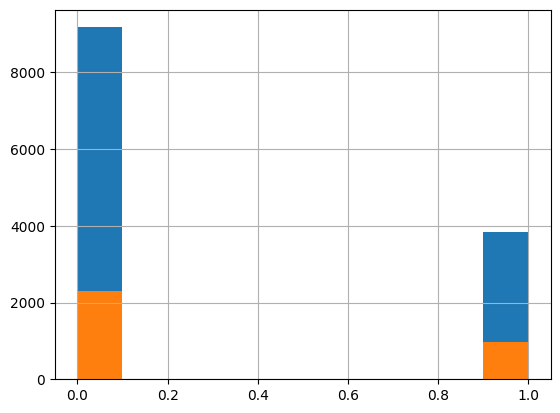

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df_train['text'],
                                                  df_train['text_type'],
                                                  train_size=0.8,
                                                  shuffle=True,
                                                  stratify=df_train['text_type'])

X_test, y_test = df_test['text'], df_test['text_type']
display(y_train.hist())
display(y_val.hist())

## Baseline

Сперва нужно преобразовать тексты в векторные представления, вначале возьмём TF-IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

encoder = TfidfVectorizer(max_features=5000)
encoder.fit(X_train)

X_train_enc = encoder.transform(X_train)
X_test_enc = encoder.transform(X_test)
X_val_enc = encoder.transform(X_val)

X_train_enc.shape, X_val_enc.shape, X_test_enc.shape

((13022, 5000), (3256, 5000), (4070, 5000))

Обучим модель логистической решгрессии на данных эмбеддингах

не рассматривал SVM, так как он обычно долго считается, при этом редко даёт сильное преимущество в метрике

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

model = LogisticRegression()
model.fit(X_train_enc, y_train)

print(f'accuracy (train): {accuracy_score(model.predict(X_train_enc), y_train)}')
print(f'accuracy (val): {accuracy_score(model.predict(X_val_enc), y_val)}')
print(f'roc_auc_score (train): {roc_auc_score(y_train, model.predict(X_train_enc))}')
print(f'roc_auc_score (val): {roc_auc_score(y_val, model.predict(X_val_enc))}')

accuracy (train): 0.9527722316080479
accuracy (val): 0.9315110565110565
roc_auc_score (train): 0.9315398601408508
roc_auc_score (val): 0.9022030715579104


Теперь давайте обучим бустинг.
Обычно он показывает качество немного лучше.
Главное - подбор гиперпараметров

In [73]:
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.7 MB/s eta 0:00:00


In [80]:
from catboost import CatBoostClassifier, Pool

cat_boost_model = CatBoostClassifier(verbose=10,
                                     learning_rate=0.5,
                                     iterations=500,
                                     eval_metric="AUC",
                                     od_wait=500,
                                     od_type='Iter')
cat_boost_model.fit(X_train_enc, y_train)

print(f'accuracy (train): {accuracy_score(cat_boost_model.predict(X_train_enc), y_train)}')
print(f'accuracy (val): {accuracy_score(cat_boost_model.predict(X_val_enc), y_val)}')
print(f'roc_auc_score (train): {roc_auc_score(y_train, cat_boost_model.predict(X_train_enc))}')
print(f'roc_auc_score (val): {roc_auc_score(y_val, cat_boost_model.predict(X_val_enc))}')

0:	total: 663ms	remaining: 5m 30s
10:	total: 4.58s	remaining: 3m 23s
20:	total: 9.12s	remaining: 3m 27s
30:	total: 15.6s	remaining: 3m 55s
40:	total: 22.5s	remaining: 4m 11s
50:	total: 27.3s	remaining: 4m
60:	total: 33.6s	remaining: 4m 1s
70:	total: 38.1s	remaining: 3m 50s
80:	total: 43.3s	remaining: 3m 43s
90:	total: 50.9s	remaining: 3m 48s
100:	total: 57s	remaining: 3m 45s
110:	total: 1m 4s	remaining: 3m 45s
120:	total: 1m 8s	remaining: 3m 33s
130:	total: 1m 10s	remaining: 3m 19s
140:	total: 1m 13s	remaining: 3m 8s
150:	total: 1m 16s	remaining: 2m 57s
160:	total: 1m 19s	remaining: 2m 46s
170:	total: 1m 21s	remaining: 2m 36s
180:	total: 1m 23s	remaining: 2m 27s
190:	total: 1m 27s	remaining: 2m 20s
200:	total: 1m 30s	remaining: 2m 14s
210:	total: 1m 32s	remaining: 2m 6s
220:	total: 1m 34s	remaining: 1m 59s
230:	total: 1m 37s	remaining: 1m 53s
240:	total: 1m 39s	remaining: 1m 47s
250:	total: 1m 43s	remaining: 1m 42s
260:	total: 1m 45s	remaining: 1m 36s
270:	total: 1m 48s	remaining: 1m 3

Модель достаточно сильно переобучилась, однако валидация показывает, что модель всё ещё лучше, чем лог-рег (как и ожидалось)

Результат хороший, что говорит о том, что задача сама по себе не особо сложная, однако давайте её улучшим. До этого мы использовали TF-IDF в качестве кодирования, в этот раз воспользуемся большой языковой моделью BERT. Она позволяет делать более осмысленные векторные представления текста

In [8]:
import torch
import transformers
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained("bert-base-uncased")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

<Axes: >

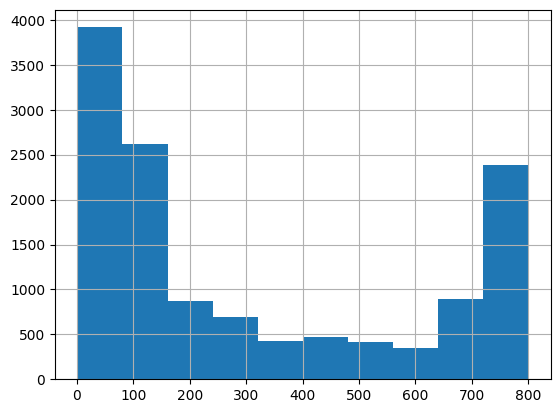

In [9]:
X_train.apply(lambda x: len(x)).hist()

Заметим, что большое кол-во сообщений достаточно длинные и содержат много информации

Создадим датасет для обучения NN

In [23]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.X = tokenizer(list(X.values), return_tensors='pt', max_length = 500, padding = 'max_length', truncation = True)
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X['input_ids'][idx], self.X['attention_mask'][idx], self.y[idx]


train_dataset = TextDataset(X_train.reset_index(drop=True), y_train.reset_index(drop=True), tokenizer)
val_dataset = TextDataset(X_val.reset_index(drop=True), y_val.reset_index(drop=True), tokenizer)
test_dataset = TextDataset(X_test.reset_index(drop=True), [0] * len(X_test), tokenizer)

In [41]:
train_loader = DataLoader(train_dataset, batch_size=64)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [42]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
bert = bert.to(device)

device

'cuda'

In [15]:
import gc
gc.collect()
torch.cuda.empty_cache()  # Очистка видеопамяти
gc.collect()

0

Добавим к bert пару линейных слоёв и посмотрим на итоговое качество \
Был выбран BCEWithLogitsLoss - это аналог кросс энтропии для бинарное классификации

In [26]:
import torch.nn as nn
from tqdm.auto import tqdm
import torch
import numpy as np

class SpamClassifier(nn.Module):
    def __init__(self, bert, hidden_layer):
        super().__init__()
        self.linear1 = nn.Linear(500, 768)
        self.bert = bert
        self.linear2 = nn.Linear(768, hidden_layer)
        self.linear3 = nn.Linear(hidden_layer, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        # out = self.linear1(input_ids.float())
        with torch.no_grad():
            embeds = self.bert(input_ids, attention_mask)
        # embeds = self.relu(out)
        out = self.linear2(embeds.pooler_output)
        out = self.relu(out)
        out = self.linear3(out)
        return out


model = SpamClassifier(bert, 256).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
epoch_cnt = 10

def train_epoch(model, optimizer, criterion, train_loader):
    losses = []
    for input_ids, attention_mask, y in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = input_ids.to(device)
        y = y.to(device)
        attention_mask = attention_mask.to(device)
        output = model(input_ids, attention_mask)
        loss = criterion(output, y.unsqueeze(1).float())
        loss.backward()

        optimizer.step()
        losses.append(loss.item())

    return np.mean(losses)


def val_epoch(model, criterion, val_loader):
    losses = []

    outputs = []
    ys = []
    for input_ids, attention_mask, y in tqdm(val_loader):
        input_ids = input_ids.to(device)
        y = y.to(device)
        attention_mask = attention_mask.to(device)
        output = model(input_ids, attention_mask)
        loss = criterion(output, y.unsqueeze(1).float())
        losses.append(loss.item())

        outputs += list(output.squeeze(1).detach().cpu())
        ys += list(y.detach().cpu())

    score = roc_auc_score(ys, outputs)
    print(f'score: {score}')
    return np.mean(losses)



def train(model, optimizer, criterion, train_loader, val_loader, epoch_cnt=10):
    for epoch in range(epoch_cnt):
        mean_train_loss = train_epoch(
            model, optimizer, criterion, train_loader
        )
        mean_val_loss = val_epoch(
            model, criterion, val_loader
        )
        print(f'epoch {epoch}')
        print(f'mean_train_loss: {mean_train_loss}')
        print(f'mean_val_loss: {mean_val_loss}')
        print('-' * 50)


train(model, optimizer, criterion, train_loader, val_loader, epoch_cnt)

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

score: 0.9342044327876935
epoch 0
mean_train_loss: 0.4527909635913138
mean_val_loss: 0.31806497246611354
--------------------------------------------------


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

score: 0.9503656379201278
epoch 1
mean_train_loss: 0.3005237856916353
mean_val_loss: 0.2652375514016432
--------------------------------------------------


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

score: 0.9567548988865466
epoch 2
mean_train_loss: 0.2642099496123253
mean_val_loss: 0.24739039338686886
--------------------------------------------------


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

score: 0.9611485353638798
epoch 3
mean_train_loss: 0.245682477403213
mean_val_loss: 0.2375473613832511
--------------------------------------------------


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

score: 0.9643286653966687
epoch 4
mean_train_loss: 0.23535832225838127
mean_val_loss: 0.2321835934531455
--------------------------------------------------


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

score: 0.9668481186571858
epoch 5
mean_train_loss: 0.227155204606699
mean_val_loss: 0.22636938504144258
--------------------------------------------------


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

score: 0.9687503964966911
epoch 6
mean_train_loss: 0.21910457331321986
mean_val_loss: 0.22015171235098557
--------------------------------------------------


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

score: 0.9695529057996364
epoch 7
mean_train_loss: 0.2125055015671487
mean_val_loss: 0.2198659660769444
--------------------------------------------------


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

score: 0.9712598806975442
epoch 8
mean_train_loss: 0.20744280831194392
mean_val_loss: 0.21321759811219046
--------------------------------------------------


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

score: 0.9723931815257011
epoch 9
mean_train_loss: 0.20197727007097474
mean_val_loss: 0.20890340106744393
--------------------------------------------------


In [33]:
train(model, optimizer, criterion, train_loader, val_loader, 3)

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

score: 0.9731281731063771
epoch 0
mean_train_loss: 0.1979087542596401
mean_val_loss: 0.2064364358198409
--------------------------------------------------


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

score: 0.9738812902500784
epoch 1
mean_train_loss: 0.19409791106248603
mean_val_loss: 0.2044959865948733
--------------------------------------------------


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

score: 0.9747540361097466
epoch 2
mean_train_loss: 0.19150091201870464
mean_val_loss: 0.20288819732034907
--------------------------------------------------


In [66]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train(model, optimizer, criterion, train_loader, val_loader, 3)

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

score: 0.9775267941135422
epoch 0
mean_train_loss: 0.1639136415632332
mean_val_loss: 0.17499148473143578
--------------------------------------------------


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

score: 0.9776781425648033
epoch 1
mean_train_loss: 0.16291462407246524
mean_val_loss: 0.17442951672801785
--------------------------------------------------


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

score: 0.977839006936653
epoch 2
mean_train_loss: 0.1621425268148967
mean_val_loss: 0.1738578093548616
--------------------------------------------------


In [67]:
torch.save(model.state_dict(), './drive/MyDrive/spam/spam_model2.pth')

In [68]:
outputs = []
for input_ids, attention_mask, _ in tqdm(test_loader):
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    output = model(input_ids, attention_mask)

    outputs += list(output.squeeze(1).detach().cpu())

  0%|          | 0/64 [00:00<?, ?it/s]

In [50]:
X_test

0       j jim whitehead ejw cse ucsc edu writes j you ...
1       original message from bitbitch magnesium net p...
2       java for managers vince durasoft who just taug...
3                    there is a youtuber name saiman says
4       underpriced issue with high return on equity t...
                              ...                        
4065    husband to wifetum meri zindagi hoorwifeor kya...
4066    baylor enron case study cindy yes i shall co a...
4067                             boring as compared to tp
4068    hellogorgeous hows u my fone was on charge lst...
4069    energy conference mark we are really swamped a...
Name: text, Length: 4070, dtype: object

In [69]:
X_test = pd.DataFrame(X_test)

In [70]:
X_test['text_type'] = [(x >= 0) * "spam" + (x < 0) * "ham" for x in outputs]

In [71]:
X_test.to_csv('./drive/MyDrive/spam/data2.csv', index=False)

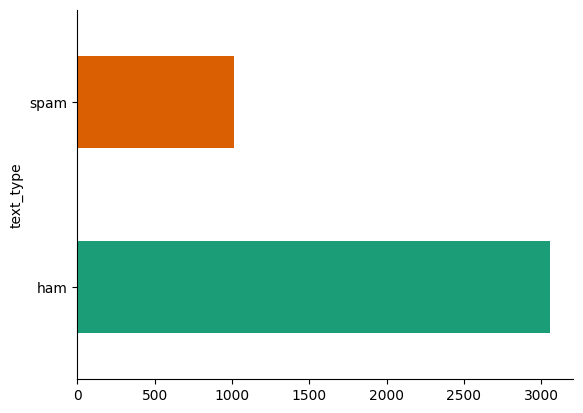

In [60]:
from matplotlib import pyplot as plt
import seaborn as sns
X_test.groupby('text_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Итак, мы смогли добиться roc-auc 97.7 по данным с валидации, это не удивительно
Если посмотреть на данные, можно легко заметить, что spam и ham сильно различаются между собой.
Эта задача не подразумевает глубинное понимание смысла предложений, так как часто наличие определённых слов достаточно, чтобы с уверенностью сказать о спаме.

От себя скажу, что сталкивался с задачей обучения классификатора на текстах. Это была модель "тех поддержки", которая по запросу должна была давать один из заготовленных ответов.
Однако в тот раз мне предоставили всего ~100 предложений для ~50 классов, что звучит достаточно грустно. 
Решение: генерация примеров с помощью LLM. Это помогло мне в той задаче, скорее всего сработало бы и в этой (если бы было мало данных). Ведь  классы spam и ham очень не похожи друг на друга, а значит LLM синтетика была бы достаточно качественной.